In [1]:
import awkward as ak
import numpy as np
import pylhe

In [2]:
pylhe.register_awkward()
events = pylhe.to_awkward(pylhe.read_lhe_with_attributes("./unweighted_events.lhe.gz"))
events.fields

/var/folders/cf/rp73zkws3232x_89lllkwqt00000gm/T/ipykernel_52016/909616642.py:1: DeprecationWarning: pylhe.awkward.register_awkward is deprecated as of pylhe v0.6.0 and will be removed in pylhe v0.8.0. Please remove use of pylhe.awkward.register_awkward in favor of automatic registration.
  pylhe.register_awkward()


['eventinfo', 'particles']

In [3]:
particle = {
    'w+': events['particles'].id == 24,
    'w-': events['particles'].id == -24,
    'e+': events['particles'].id == -11,
    'e-': events['particles'].id == 11,
}

In [4]:
four_momentum = {
    p: ak.flatten(events['particles'][particle[p]].vector) for p in particle
}

four_momentum

{'w+': <MomentumArray4D [{x: 1.1, y: -8.19, ... t: 665}] type='100000 * Momentum4D["x":...'>,
 'w-': <MomentumArray4D [{x: -1.1, y: 8.19, ... t: 133}] type='100000 * Momentum4D["x":...'>,
 'e+': <MomentumArray4D [{x: 6.92, y: 33.2, ... t: 411}] type='100000 * Momentum4D["x":...'>,
 'e-': <MomentumArray4D [{x: -3.27, y: -20.5, ... t: 94.3}] type='100000 * Momentum4D["...'>}

In [5]:
events['particles'][particle['w+']].vector.to_Vector3D(), events['particles'][particle['e+']].vector.to_Vector3D()

(<MomentumArray3D [[{x: 1.1, y: -8.19, ... z: 659}]] type='100000 * var * Momentu...'>,
 <MomentumArray3D [[{x: 6.92, y: 33.2, ... z: 406}]] type='100000 * var * Momentu...'>)

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import os
import boost_histogram as bh

plt.style.use(hep.style.ROOT)

def plot(array, x_name, plot_name, density=True, bins=20, x_min=0, x_max=0.1):
    ## canvas initializing
    plt.figure(figsize=(9,9))
    ax=plt.gca()
    plt.grid()
    #hep.cms.label(data=False, year=2017, ax=ax, fontname='sans-serif')
    
    ## plot
    for channel, array in array.items():
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        hist.fill(array)
        h, var = hist.view().value, hist.view().variance
        hep.histplot(h, bins=hist.axes[0].edges, yerr=np.sqrt(var), label=channel, histtype='step', density=density, stack=False)
    
    ## axises
    plt.xlim(x_min, x_max)
    plt.ylim(0, ax.get_ylim()[1]*1.25)
    # x_major_locator=plt.MultipleLocator(0.1)
    # y_major_locator=MultipleLocator(1)
    # ax.xaxis.set_major_locator(x_major_locator)
    # ax.yaxis.set_major_locator(y_major_locator)
    plt.xticks(size=14)
    plt.yticks(size=14)
    if density==False:
        plt.ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        plt.ylabel('A.U.', fontsize=20, ha='right', y=1)
    plt.xlabel(x_name, fontsize=22, ha='right', x=1)

    ## title, text and legend
    #plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    plt.legend(loc='best',frameon=False,fontsize=24)
    #plt.text(0.1, 0.9e-1,r"$\rm 90GeV<m_{SD}<140GeV$", fontsize=16,color="black")
    #plt.text(0.1, 0.2e-1,"AUC(MD)=%.4f"%(roc_auc_new), fontsize=20,color="red")
    #plt.text(0.5, 0.2e-3,"AUC(non-MD)=%.4f"%(roc_auc_old), fontsize=20,color='blue')
    if not os.path.exists('plots'):
        os.makedirs('plots')
    plt.savefig(f"plots/{plot_name}.pdf", bbox_inches='tight')
    plt.show()

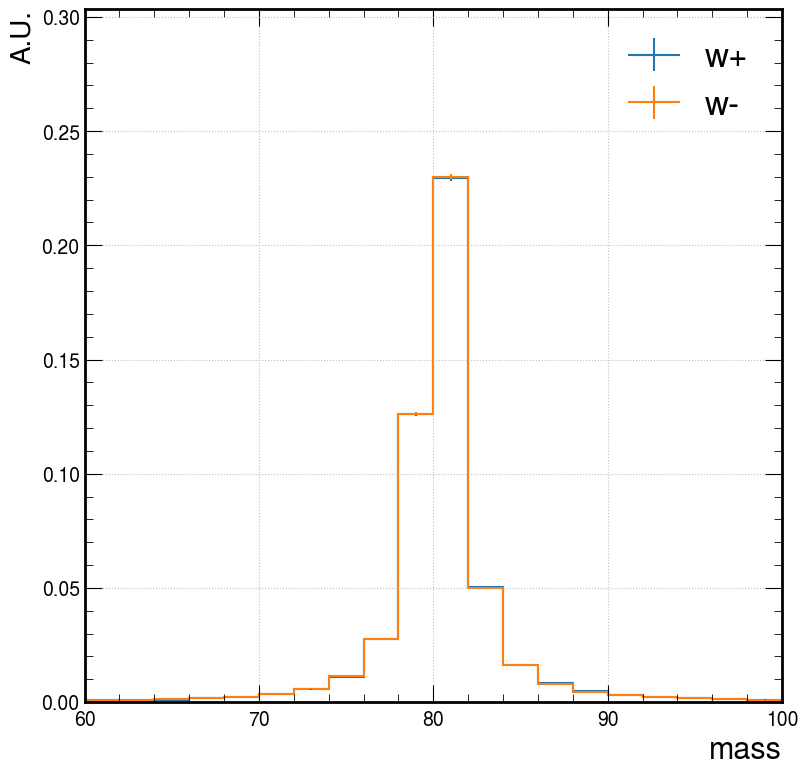

In [7]:
mass = {
    p: ak.flatten(events['particles'][particle[p]].m) for p in particle if p.startswith('w')
}

plot(array=mass, x_name='mass', plot_name='mass', density=True, bins=20, x_min=60, x_max=100)

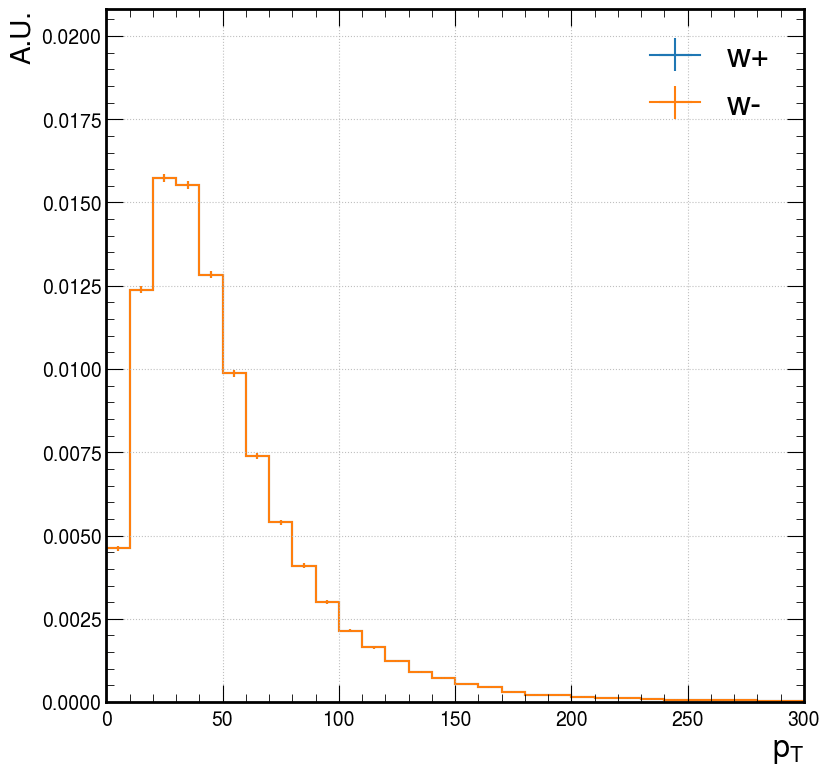

In [8]:
pt = {
    p: ak.flatten(events['particles'][particle[p]].vector.pt) for p in particle if p.startswith('w')
}
plot(array=pt, x_name=r'$p_T$', plot_name='pt', density=True, bins=30, x_min=0, x_max=300)

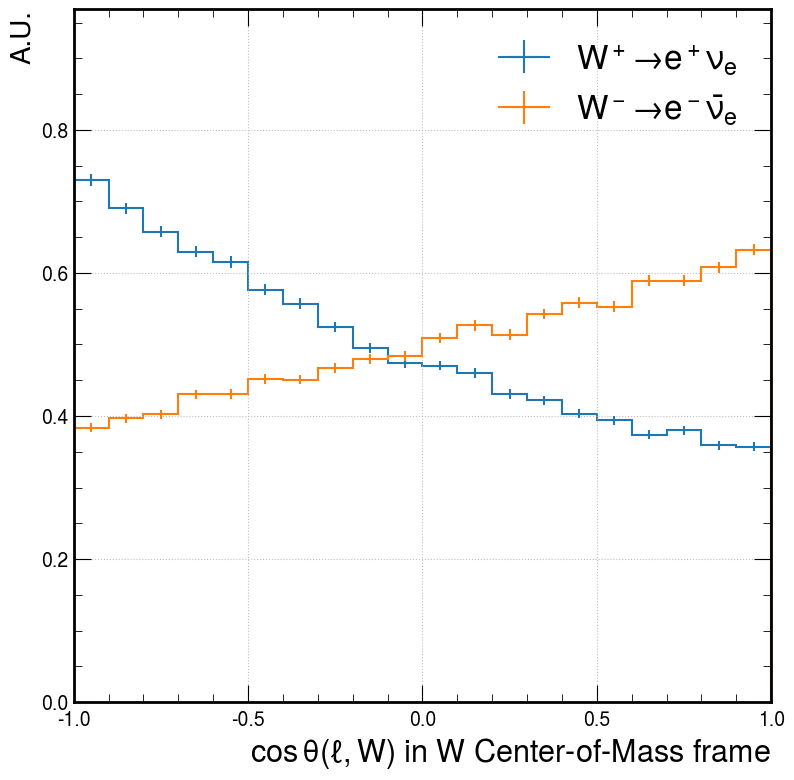

In [9]:
cos_helicity = {
    r'$W^+\to e^+\nu_e$': four_momentum['e+'].boostCM_of(four_momentum['w+']).to_Vector3D().unit().dot(four_momentum['w+'].to_Vector3D().unit()),
    r'$W^-\to e^-\bar{\nu}_e$': four_momentum['e-'].boostCM_of(four_momentum['w-']).to_Vector3D().unit().dot(four_momentum['w-'].to_Vector3D().unit()),
}
plot(array=cos_helicity, x_name=r'$\cos\theta(\ell, W)$ in W Center-of-Mass frame', plot_name='helicity', density=True, bins=20, x_min=-1, x_max=1)